# 2025-02-24: What is up with the raw adata, the copy function and the layers in scanpy?!
#### By [Aishwarya Chander](aishwarya.chander@alleninstitute.org), High Resolution Translational Immunology, Allen Institute for Immunology

## Project

### 1. Experiment: I cant figure out what's happening with the adata matrix in the current version of scanpy so I'm trying to check the scale, shape and sparsity at each processing step.

### 2. Key results:

Where you place your raw saving code matters. 
| Placement of `.raw`         | What Happens                                 | Effect on Analysis                                       |
|-----------------------------|----------------------------------------------|----------------------------------------------------------|
| Before QC Filtering         | Keeps low-quality cells in `.raw`           | Can introduce bias in downstream DE analysis             |
| After QC Filtering         | Removed all low-quality cells in `.raw`           | Can recover all genes for QC'd cells            |
| After Normalization         | `.raw.X` stores log-transformed data         | DE analyses may use log-transformed instead of raw counts |
| After HVG Selection         | `.raw` contains only highly variable genes   | Can't recover full gene set later, bad for DE analysis   |


1. Save your `.raw` data before you do any normalization. Let this be your first step after QC filtering.
2. When you save your counts as layers, the layer gets modified based on any subsetting you do in your `var` space. So if you get rid of HVGs in your object, the corresponding genes for these go away in your layers. Your `.layer['counts']` thus does not effectively preserve your `adata.raw.X` as is.
3. A basic `sc.pp.scale` will 0 center your data make it a dense matrix. This takes forever in bigger datasets and will take a ton of space. To avoid the sparse -> dense conversion, use `sc.pp.scale(adata, zero_center=False)`. I do this for any object bigger than 100k cells to keep things light and breezy.
4. If you don't save the data in a `raw` or `.layer['counts']`, the consequences are:
    1. You wont have raw data for DE testing.
    2. You wont be able to use the `use_raw` function.
    3. You wont have all genes if you HVG subset.
    4. You wont be able to recover your base matrix if you decide you subset your object later.
6. As soon as you run `adata = adata.raw.to_adata()` to bring back your raw matrix, run `adata.raw = adata` to re-preserve the `raw` object after this round of processing.


### 3. My workflow:

```
1. adata.layers["counts"] = adata.X.copy()
2. sc.pp.calculate_qc_metrics()
3. Remove Outliers
4. adata.raw = adata
5. sc.pp.normalize_total(), sc.pp.log1p()
6. sc.pp.highly_variable_genes(), subset HVGs
7. sc.pp.scale()
8. sc.tl.pca()
9. sc.pp.neighbors()
10. sc.tl.umap()
11. sc.tl.leiden()
12. sc.tl.rank_genes_groups(use_raw=True) OR sc.tl.rank_genes_groups(use_raw=False, layer='counts')

```

### 4. Function I use to process datasets with 30K+ cells: 
If you have fewer cells, just tweak some parameters like PCA, UMAP, Leiden etc.

```python
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

def process_adata(adata, harmony=False, harmony_key=None):

    # Store raw counts
    adata.layers["counts"] = adata.X.copy()
    
    # Mitochondrial genes
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    # Ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    # Hemoglobin genes
    adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
    
    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)
    
    # Identify outliers
    adata.obs["outlier"] = (
        is_outlier(adata, "log1p_total_counts", 5)
        | is_outlier(adata, "log1p_n_genes_by_counts", 5)
        | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
    )
    
    adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
        adata.obs["pct_counts_mt"] >= 6
    )

    adata = adata[adata.obs["doublet_score"] < 0.3].copy()
    adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

    # Save raw counts
    adata.raw = adata
    
    # Normalizing to median total counts and logarithmize the data
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    
    # Identify and subset highly variable genes
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.25)
    adata = adata[:, adata.var_names[adata.var['highly_variable']]].copy()
    
    # Scale the data
    sc.pp.scale(adata, max_value=10, zero_center=False)
    
    # Perform PCA
    sc.tl.pca(adata, svd_solver='arpack')
    adata.obsm['X_pca_temp'] = adata.obsm['X_pca']

    # Run Harmony if True
    if harmony: 
        sce.pp.harmony_integrate(adata, key=harmony_key)
        adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']
    
    # Compute neighbors, UMAP and leiden
    sc.pp.neighbors(adata, n_neighbors=50, use_rep='X_pca', n_pcs=20)
    sc.tl.umap(adata, min_dist=0.45, random_state=0, n_components=2)
    sc.tl.leiden(adata, resolution=1, n_iterations=2)
    sc.tl.rank_genes_groups(adata, 'leiden', method='t-test', key_added='t-test', use_raw=False, layer='counts')
    
    return adata

```

## Part 1: Workflow

In [1]:
%run ../private/general_code/global_interaction_functions.py
sc.settings.n_jobs = 30

### Set up
> Load in an adata object that has not been processed. This just has the metadata. 

In [2]:
adata = sc.read_h5ad('any_adata_path_here')

In [3]:
adata.shape

(40657, 33538)

> Subsample to 3k cells for fast testing

In [4]:
sc.pp.subsample(adata, n_obs=3000)

In [5]:
adata.shape

(3000, 33538)

In [6]:
adata

AnnData object with n_obs × n_vars = 3000 × 33538
    obs: 'adt_qc_flag', 'adt_umis', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'ext_l1', 'ext_l2', 'ext_l3', 'healthy_l1', 'healthy_l2', 'healthy_l3', 'aifi_l1', 'aifi_l2', 'aifi_l3', 'predicted_doublet', 'doublet_score', 'sample.sampleKitGuid', 'sample.visitDetails', 'sample.drawDate', 'sample.daysSinceFirstVisit', 'sample.diseaseStatesRecordedAtVisit', 'subject.biologicalSex', 'subject.birthYear', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'manual.time_stamp', 'manual.tissue', 'manual.disease_condition', 'manual.response', 'manual.response_type', 'manual.extracted_name', 'manual.file_paths', 'manual.batch_id', 'manual.cmv.ab_screen_index_value', 'manual.cmv.ab_screen_

> Save the input matrix as a layer. At this point there has been no processing other than adding metadata.

In [7]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'uint16'
	with 5989451 stored elements and shape (3000, 33538)>

In [8]:
raw_counts = adata.X
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.9404709980721241
Miniumum value: 0
Maximum value: 21119


### Step 1: Save your counts matrix as a `layer`.

> Lets save this as an adata layer. Basically, we're adding a layer to the H5AD that is storing the current state of `X`. Techinically, I am supposed to use `.copy()` to ensure you're preserving this through any changes to `X` in the future. 

In [9]:
adata.layers['raw_counts'] = adata.X.copy()

In [10]:
adata.layers['raw_counts']

<Compressed Sparse Row sparse matrix of dtype 'uint16'
	with 5989451 stored elements and shape (3000, 33538)>

In [11]:
raw_counts = adata.layers['raw_counts']
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.9404709980721241
Miniumum value: 0
Maximum value: 21119


### Step 2: QC and subset your data

> Run some basic QC

In [12]:
# Mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')
# Ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(('RPS', 'RPL'))

sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], inplace=True)
adata = adata[(adata.obs['n_genes_by_counts'] > 200) & (adata.obs['pct_counts_mt'] < 5)].copy()

### Step 3: Save `raw` post QC

> Now, after QC we will save an adata in the `raw` space. Make sure this is empty. This will let us use the `adata.raw` for any downstream plotting and things like DEG analysis on the raw counts.

In [13]:
adata.raw.X

AttributeError: 'NoneType' object has no attribute 'X'

In [14]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'uint16'
	with 3333110 stored elements and shape (1606, 33538)>

In [15]:
raw_counts = adata.X
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.9381176289908189
Miniumum value: 0
Maximum value: 21119


In [16]:
adata.raw = adata.copy()  # Preserve original counts

> So the whole matrix MINUS any sus bad qc cells are now saved within `adata.raw`. At this time, our `adata.raw`, `adata.X` and `adata.layers['raw_counts']` all have the same type of input. Notice here that even though I didnt change `adata.layers['raw_counts']`, it automatically became a subset...

In [17]:
adata.raw.X

<Compressed Sparse Row sparse matrix of dtype 'uint16'
	with 3333110 stored elements and shape (1606, 33538)>

In [18]:
raw_counts = adata.raw.X
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.9381176289908189
Miniumum value: 0
Maximum value: 21119


In [19]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'uint16'
	with 3333110 stored elements and shape (1606, 33538)>

In [20]:
raw_counts = adata.X
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.9381176289908189
Miniumum value: 0
Maximum value: 21119


In [21]:
adata.layers['raw_counts']

<Compressed Sparse Row sparse matrix of dtype 'uint16'
	with 3333110 stored elements and shape (1606, 33538)>

In [22]:
raw_counts = adata.layers['raw_counts']
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.9381176289908189
Miniumum value: 0
Maximum value: 21119


### Step 4: Normalize and log1p transform data

> Okay, here I'll finally make some changes to the base matrix by doing a normalization and a log1p. 

In [23]:
sc.pp.normalize_total(adata)  # Normalize to total counts
sc.pp.log1p(adata)  # Log-transform the data

adata.layers['log1p_counts'] = adata.X.copy()

> `adata.raw.X` stays the same...

In [24]:
adata.raw.X

<Compressed Sparse Row sparse matrix of dtype 'uint16'
	with 3333110 stored elements and shape (1606, 33538)>

In [25]:
raw_counts = adata.raw.X
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.9381176289908189
Miniumum value: 0
Maximum value: 21119


> `adata.X` is now log1p transformed...

In [26]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3333110 stored elements and shape (1606, 33538)>

In [27]:
raw_counts = adata.X
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.9381176289908189
Miniumum value: 0.0
Maximum value: 8.219049969145246


> `adata.layers['raw_counts']` stays the same...

In [28]:
adata.layers['raw_counts']

<Compressed Sparse Row sparse matrix of dtype 'uint16'
	with 3333110 stored elements and shape (1606, 33538)>

In [29]:
raw_counts = adata.layers['raw_counts']
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.9381176289908189
Miniumum value: 0
Maximum value: 21119


### Step 5: Calculate and supset down to HVGs

> Lets subset HVGs. Note that I'm using the `.copy()` to ensure that only `adata.X` changes and everything else stays the same.

In [30]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.25)
adata = adata[:, adata.var['highly_variable']].copy()

> `adata.raw.X` stays the same...

In [31]:
adata.raw.X

<Compressed Sparse Row sparse matrix of dtype 'uint16'
	with 3333110 stored elements and shape (1606, 33538)>

In [32]:
raw_counts = adata.raw.X
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.9381176289908189
Miniumum value: 0
Maximum value: 21119


> `adata.X` now has only the HVGs in `.var` and the maximum values have dropped with the loss of those genes...

In [33]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1043947 stored elements and shape (1606, 5017)>

In [34]:
raw_counts = adata.X
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.8704346690740252
Miniumum value: 0.0
Maximum value: 6.693673394014906


> annnnd for some reason even though I used the `.copy()` function, `adata.layers['raw_counts']` now has only the HVGs in `.var` and the maximum values have dropped with the loss of those genes...
> 
> So we can see that saving the data in `adata.layers['raw_counts']` basically does nothing to protect it from any filtering. 

In [35]:
adata.layers['raw_counts']

<Compressed Sparse Row sparse matrix of dtype 'uint16'
	with 1043947 stored elements and shape (1606, 5017)>

In [36]:
raw_counts = adata.layers['raw_counts']
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.8704346690740252
Miniumum value: 0
Maximum value: 3006


### Step 6: Scale the data

> Let's move on and scale the data.

In [37]:
sc.pp.scale(adata, max_value=10)

> `raw` is unchanged.

In [38]:
adata.raw.X

<Compressed Sparse Row sparse matrix of dtype 'uint16'
	with 3333110 stored elements and shape (1606, 33538)>

In [39]:
raw_counts = adata.raw.X
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.9381176289908189
Miniumum value: 0
Maximum value: 21119


> Not only is `adata.X` different, its now ALSO a dense scaled matrix. You can see that after scaling the sparsity reduces by A LOT.

In [40]:
adata.X

array([[-0.28886133, -0.14728796, -0.55628448, ..., -0.57205943,
        -0.09769635, -0.52180199],
       [-0.28886133, -0.14728796, -0.55628448, ..., -0.57205943,
         3.15226178, -0.52180199],
       [-0.28886133, -0.14728796, -0.55628448, ..., -0.57205943,
        -0.09769635, -0.52180199],
       ...,
       [-0.28886133, -0.14728796, -0.55628448, ...,  2.30848677,
        -0.09769635,  2.86632316],
       [-0.28886133, -0.14728796,  2.31718545, ..., -0.57205943,
        -0.09769635, -0.52180199],
       [-0.28886133, -0.14728796, -0.55628448, ..., -0.57205943,
        -0.09769635, -0.52180199]])

In [41]:
raw_counts = adata.X
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.0
Miniumum value: -4.6998273038487035
Maximum value: 10.0


> `adata.layers['raw_counts']` remains unscaled and as the same as when it underwent HVG subsetting.

In [42]:
adata.layers['raw_counts']

<Compressed Sparse Row sparse matrix of dtype 'uint16'
	with 1043947 stored elements and shape (1606, 5017)>

In [43]:
raw_counts = adata.layers['raw_counts']
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.8704346690740252
Miniumum value: 0
Maximum value: 3006


### Step 7: Compute PCA and neighbors
> These steps just add arrays to the H5AD so we should see 0 change to any of the matrices. 

In [44]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)

In [45]:
adata.raw.X

<Compressed Sparse Row sparse matrix of dtype 'uint16'
	with 3333110 stored elements and shape (1606, 33538)>

In [46]:
raw_counts = adata.raw.X
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.9381176289908189
Miniumum value: 0
Maximum value: 21119


In [47]:
adata.X

array([[-0.28886133, -0.14728796, -0.55628448, ..., -0.57205943,
        -0.09769635, -0.52180199],
       [-0.28886133, -0.14728796, -0.55628448, ..., -0.57205943,
         3.15226178, -0.52180199],
       [-0.28886133, -0.14728796, -0.55628448, ..., -0.57205943,
        -0.09769635, -0.52180199],
       ...,
       [-0.28886133, -0.14728796, -0.55628448, ...,  2.30848677,
        -0.09769635,  2.86632316],
       [-0.28886133, -0.14728796,  2.31718545, ..., -0.57205943,
        -0.09769635, -0.52180199],
       [-0.28886133, -0.14728796, -0.55628448, ..., -0.57205943,
        -0.09769635, -0.52180199]])

In [48]:
raw_counts = adata.X
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.0
Miniumum value: -4.6998273038487035
Maximum value: 10.0


In [49]:
adata.layers['raw_counts']

<Compressed Sparse Row sparse matrix of dtype 'uint16'
	with 1043947 stored elements and shape (1606, 5017)>

In [50]:
raw_counts = adata.layers['raw_counts']
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.8704346690740252
Miniumum value: 0
Maximum value: 3006


### Step 8: Plot UMAP & compute leiden clusters
> These steps just add arrays to the H5AD so we should see 0 change to any of the matrices.

In [51]:
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1)

In [52]:
adata.raw.X

<Compressed Sparse Row sparse matrix of dtype 'uint16'
	with 3333110 stored elements and shape (1606, 33538)>

In [53]:
raw_counts = adata.raw.X
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.9381176289908189
Miniumum value: 0
Maximum value: 21119


In [54]:
adata.X

array([[-0.28886133, -0.14728796, -0.55628448, ..., -0.57205943,
        -0.09769635, -0.52180199],
       [-0.28886133, -0.14728796, -0.55628448, ..., -0.57205943,
         3.15226178, -0.52180199],
       [-0.28886133, -0.14728796, -0.55628448, ..., -0.57205943,
        -0.09769635, -0.52180199],
       ...,
       [-0.28886133, -0.14728796, -0.55628448, ...,  2.30848677,
        -0.09769635,  2.86632316],
       [-0.28886133, -0.14728796,  2.31718545, ..., -0.57205943,
        -0.09769635, -0.52180199],
       [-0.28886133, -0.14728796, -0.55628448, ..., -0.57205943,
        -0.09769635, -0.52180199]])

In [55]:
raw_counts = adata.X
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.0
Miniumum value: -4.6998273038487035
Maximum value: 10.0


In [56]:
adata.layers['raw_counts']

<Compressed Sparse Row sparse matrix of dtype 'uint16'
	with 1043947 stored elements and shape (1606, 5017)>

In [57]:
raw_counts = adata.layers['raw_counts']
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.8704346690740252
Miniumum value: 0
Maximum value: 3006


### Step 9: View results
> See the raw vs not raw results on UMAPs. Raw counts show you how many # of transcripts you see wheras `X` shows you the scaled data matrix. By default, it looks like the plot uses the `raw` data to show results.

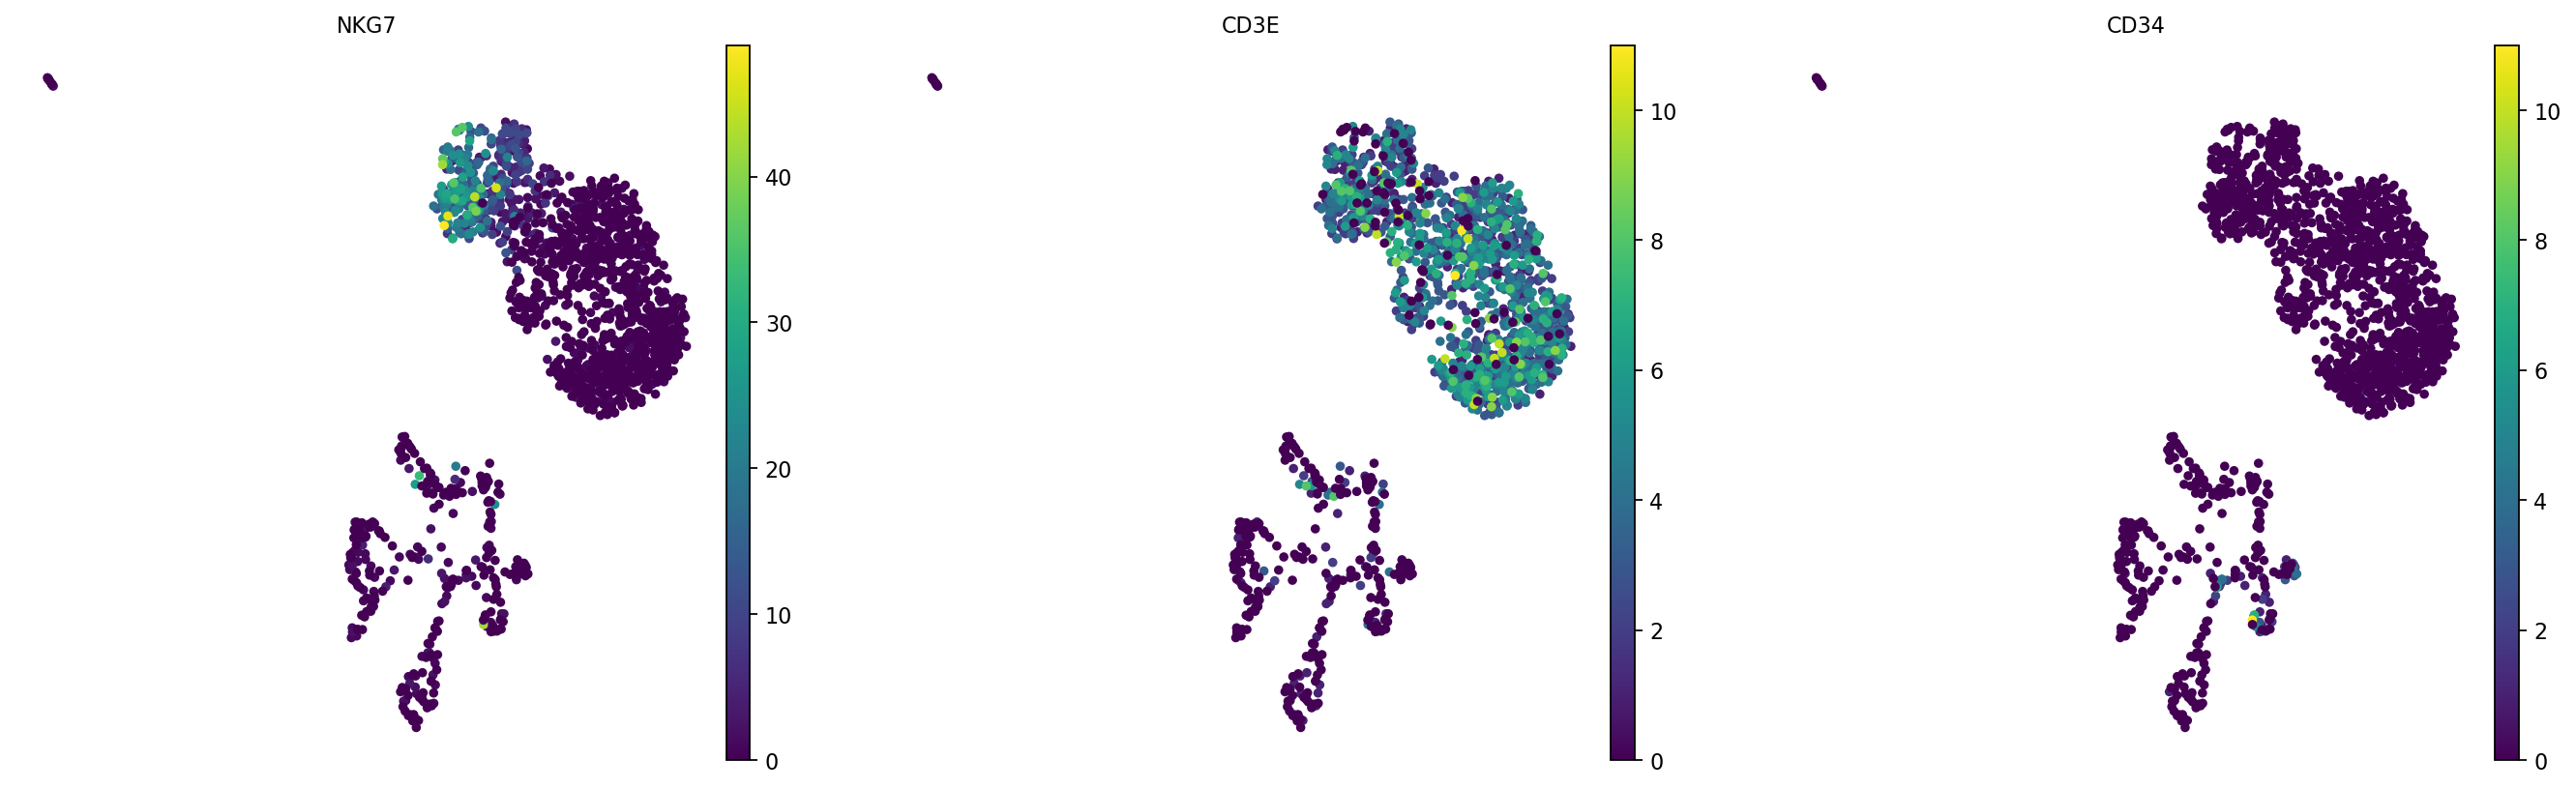

In [58]:
sc.pl.umap(adata, 
           color=['NKG7', 'CD3E', 'CD34'])

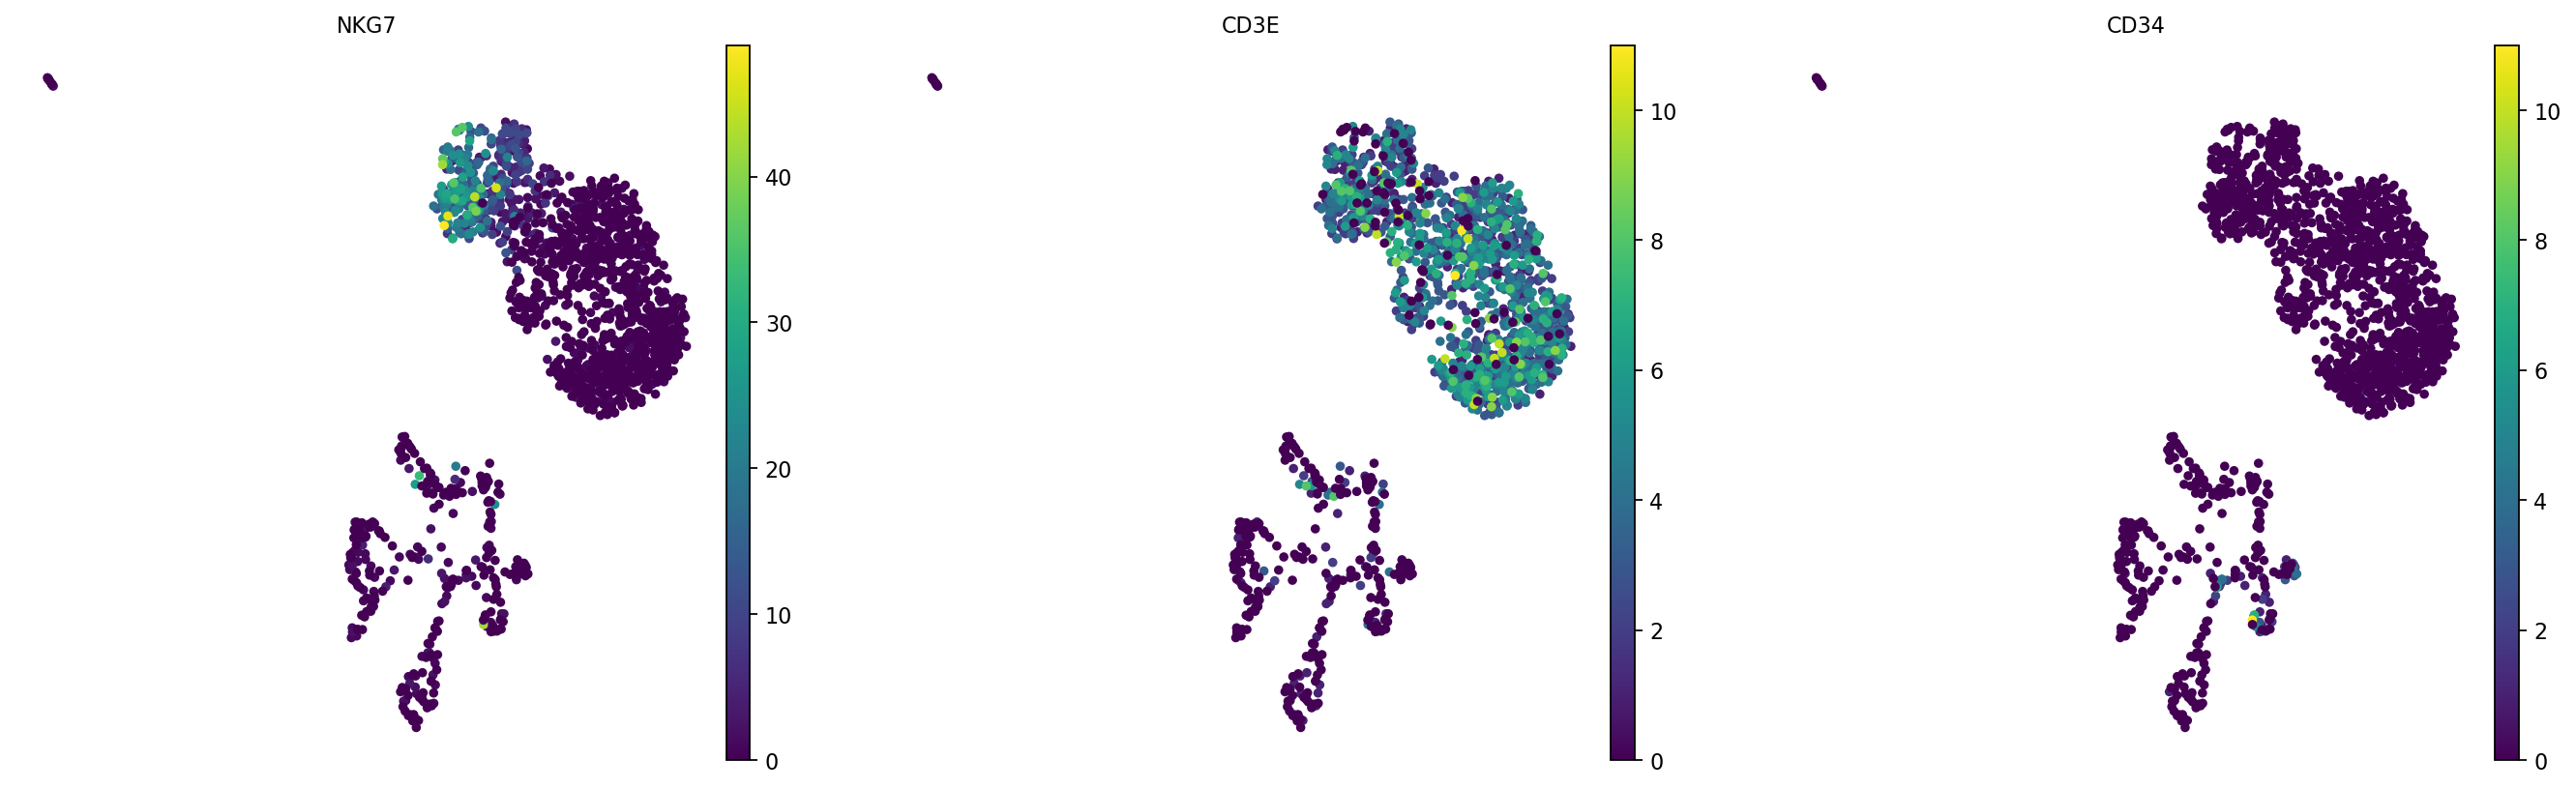

In [59]:
sc.pl.umap(adata, 
           color=['NKG7', 'CD3E', 'CD34'], 
           use_raw=True)

> Important thing to keep in mind here is if you dont use raw and your genes have been subset out, you wont see them on the umap you're trying to plot. 

KeyError: 'Could not find key CD3E in .var_names or .obs.columns.'

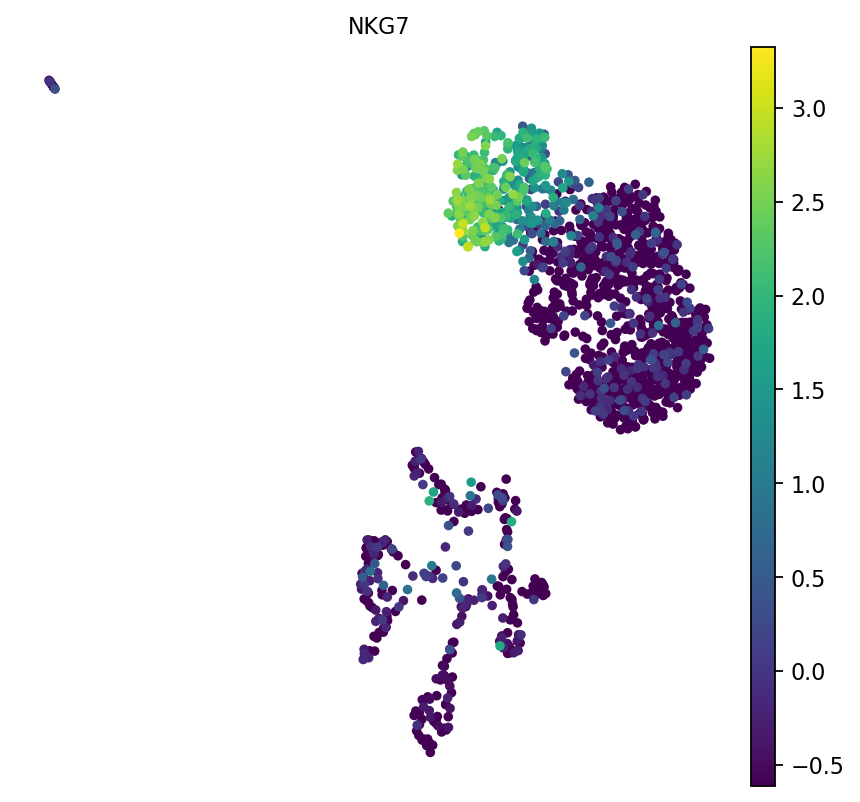

In [60]:
sc.pl.umap(adata, 
           color=['NKG7', 'CD3E', 'CD34'], 
           use_raw=False)

In [61]:
adata.write('dummy_obj.h5ad')

### Step 10: DEG analysis
> This is where having the raw data is important. So, no raw data = DEG on the log1p counts which sucks.

#### 10.1 DE Testing with no additional conditions
Uses all `raw` data by default

In [62]:
sc.tl.rank_genes_groups(adata, 
                        'leiden', 
                        method='t-test', 
                        key_added = 't-test')

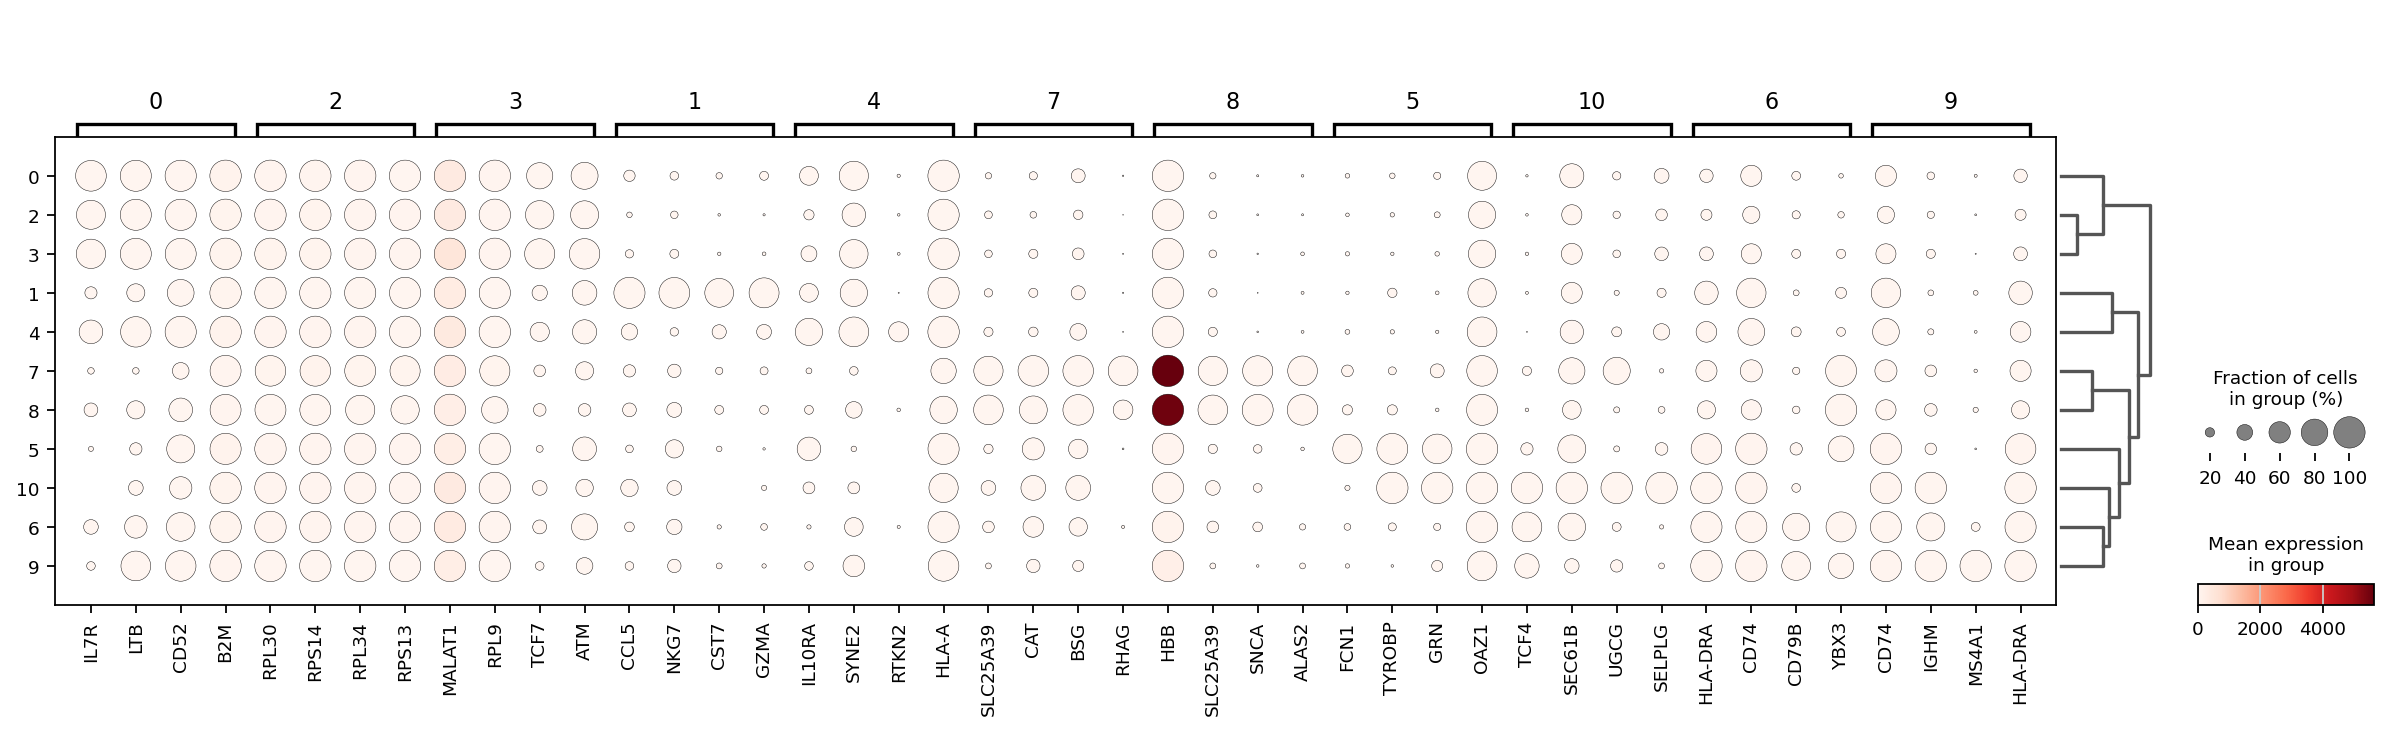

In [63]:
sc.tl.dendrogram(adata, groupby='leiden')
sc.pl.rank_genes_groups_dotplot(adata, n_genes=4, key='t-test', groupby='leiden')

In [64]:
result = adata.uns['t-test']
groups = result['names'].dtype.names
df = pd.DataFrame(
    {group + '_' + key[:5]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'pvals_adj', 'scores']})

threshold = 0.05
significant_mask = pd.concat(
    [df[group + '_pvals'] < threshold for group in groups], axis=1).any(axis=1)
significant_df = df[significant_mask]
significant_df.head()

,0_names,0_logfo,0_pvals,0_score,1_names,1_logfo,1_pvals,1_score,2_names,2_logfo,...,8_pvals,8_score,9_names,9_logfo,9_pvals,9_score,10_names,10_logfo,10_pvals,10_score
0,IL7R,13.007256,2.162671e-50,18.018177,CCL5,23.517994,5.467534e-89,28.034555,RPL30,17.660221,...,3.401449e-14,11.445103,CD74,29.362583,4.030045e-13,14.234459,TCF4,30.442772,0.000005,11.415246
1,LTB,11.158408,7.855980e-34,14.124372,NKG7,18.522038,8.507725e-69,22.830355,RPS14,18.948986,...,8.812125e-13,10.328140,IGHM,21.110868,4.170183e-10,10.951138,SEC61B,15.677767,0.000009,10.702666
2,CD52,5.160665,3.064265e-32,13.455611,CST7,6.966251,9.839676e-69,22.593266,RPL34,14.973823,...,1.479679e-12,10.259623,MS4A1,12.930360,4.881023e-08,8.668327,UGCG,24.207561,0.000014,10.202518
3,B2M,23.827585,3.496619e-26,11.782855,GZMA,9.301077,2.225321e-70,22.254791,RPS13,9.431920,...,4.877706e-12,9.878640,HLA-DRA,19.429686,3.492959e-08,8.549418,SELPLG,3.508409,0.000017,9.780040
4,KLF2,5.210338,2.825810e-24,11.546750,CD8A,5.452427,7.481918e-48,17.549295,RPS27,15.929375,...,1.251997e-11,9.612137,CD37,9.441828,9.785075e-08,8.327408,IRF8,26.656034,0.000023,9.627626


#### 10.2 DE Testing with `use_raw = Flase`
Uses the transcripts but I think it's using the HVG data here? I dont know what compartment it's pulling from.

In [65]:
sc.tl.rank_genes_groups(adata, 
                        'leiden', 
                        method='t-test', 
                        key_added = 't-test', 
                        use_raw = False)

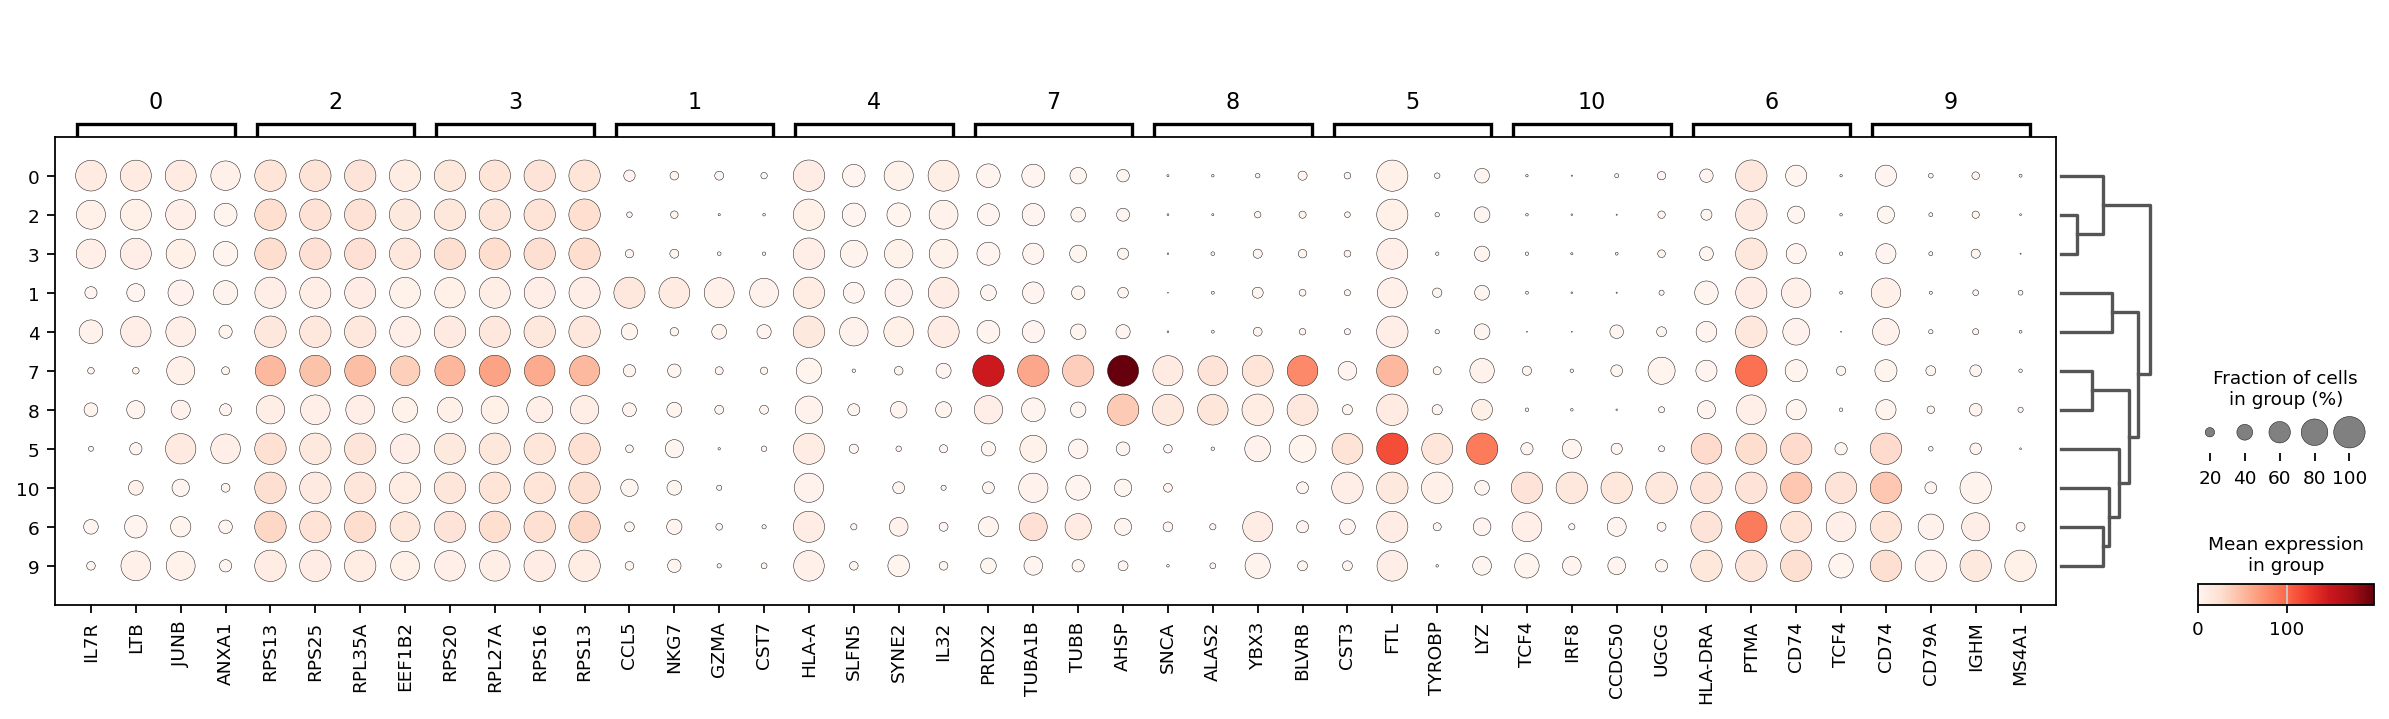

In [66]:
sc.tl.dendrogram(adata, groupby='leiden')
sc.pl.rank_genes_groups_dotplot(adata, n_genes=4, key='t-test', groupby='leiden')

In [67]:
result = adata.uns['t-test']
groups = result['names'].dtype.names
df = pd.DataFrame(
    {group + '_' + key[:5]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'pvals_adj', 'scores']})

threshold = 0.05
significant_mask = pd.concat(
    [df[group + '_pvals'] < threshold for group in groups], axis=1).any(axis=1)
significant_df = df[significant_mask]
significant_df.head()

,0_names,0_logfo,0_pvals,0_score,1_names,1_logfo,1_pvals,1_score,2_names,2_logfo,...,8_pvals,8_score,9_names,9_logfo,9_pvals,9_score,10_names,10_logfo,10_pvals,10_score
0,IL7R,NaN,1.898019e-119,28.831329,CCL5,NaN,3.011446e-253,73.308189,RPS13,NaN,...,1.619821e-30,26.587200,CD74,NaN,9.820461e-21,25.430075,TCF4,NaN,1.140084e-14,59.400673
1,LTB,NaN,2.493926e-95,24.288128,NKG7,NaN,8.815877e-166,49.897305,RPS25,NaN,...,8.501839e-26,21.094982,CD79A,NaN,1.775475e-18,23.836264,IRF8,NaN,1.406228e-10,32.209240
2,JUNB,NaN,7.177359e-54,17.321672,GZMA,NaN,6.499202e-156,43.984249,RPL35A,NaN,...,1.360740e-26,20.450212,IGHM,NaN,1.138274e-17,22.164236,CCDC50,NaN,4.570845e-10,28.395710
3,ANXA1,NaN,3.546387e-49,16.539070,CST7,NaN,4.095293e-120,35.646999,EEF1B2,NaN,...,8.501839e-26,20.373009,MS4A1,NaN,7.705768e-16,18.956068,UGCG,NaN,8.009833e-10,26.656876
4,S100A4,NaN,3.046058e-46,15.679776,CTSW,NaN,2.794444e-83,25.880772,RPS16,NaN,...,2.553310e-25,20.360325,HLA-DRA,NaN,2.484247e-15,17.255064,CD74,NaN,5.690288e-11,25.986086


#### 10.3 DE Testing with `use_raw = True`
Goes back to using the `raw` data component.

In [68]:
sc.tl.rank_genes_groups(adata, 
                        'leiden', 
                        method='t-test', 
                        key_added = 't-test', 
                        use_raw = True)

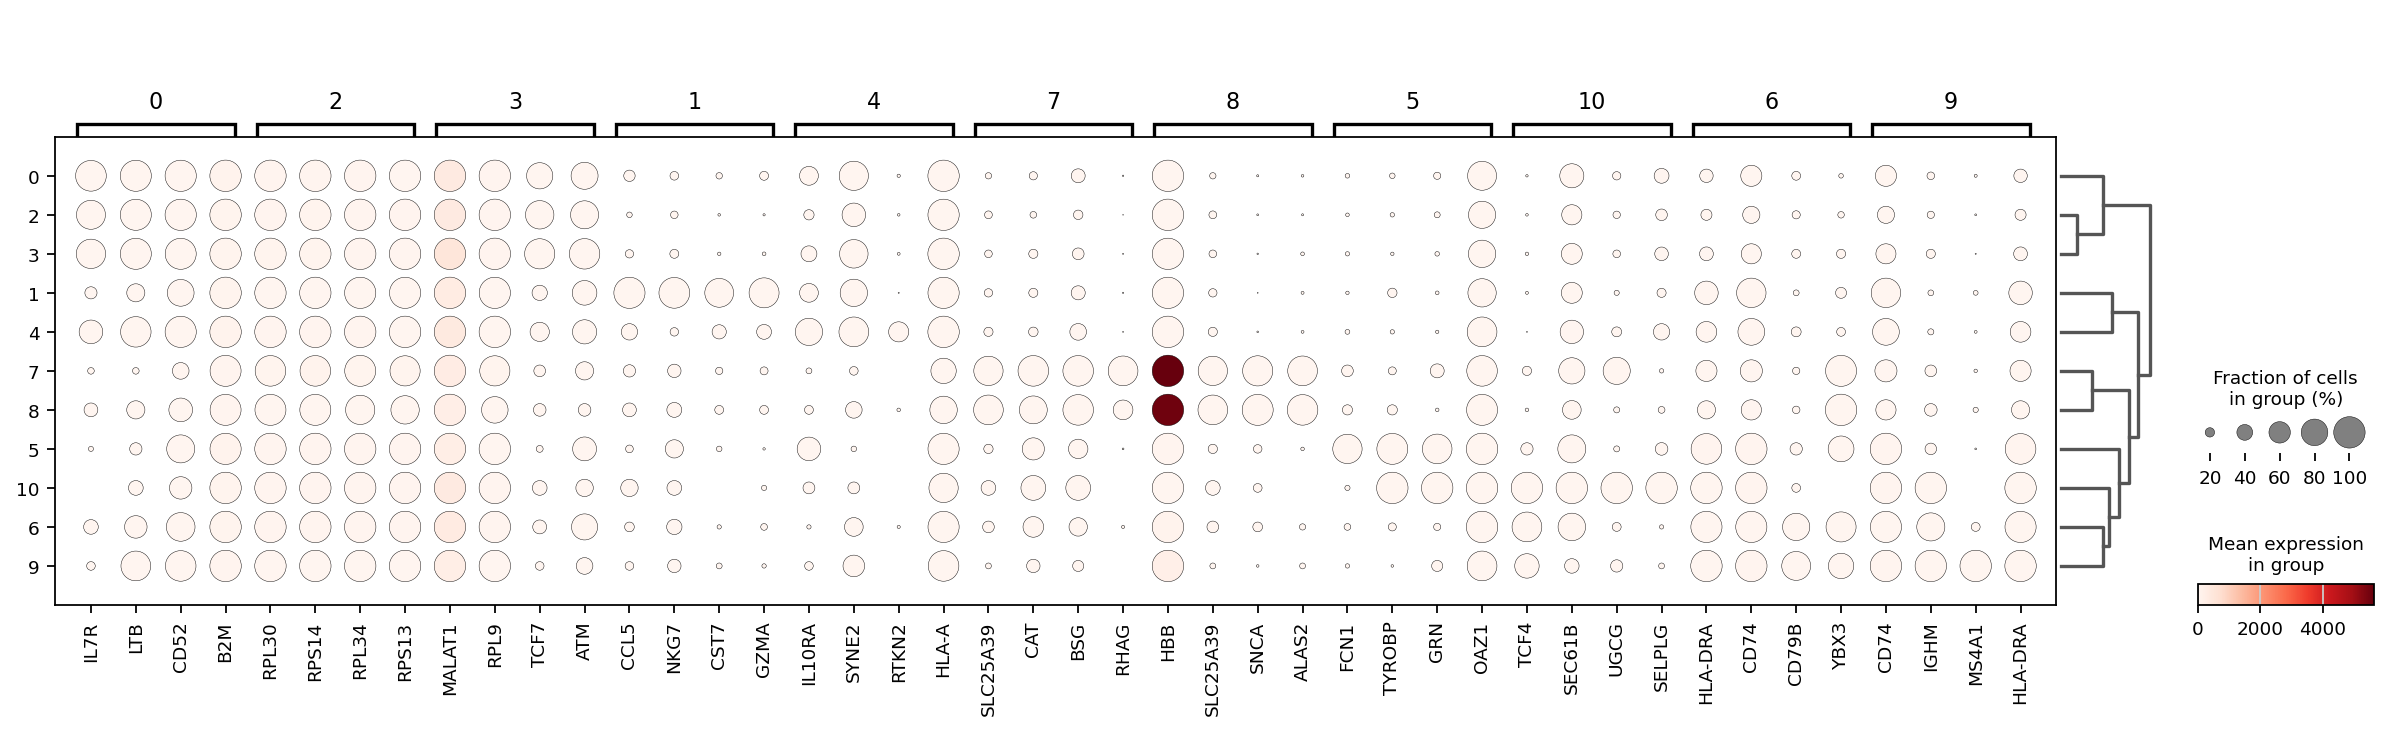

In [69]:
sc.tl.dendrogram(adata, groupby='leiden')
sc.pl.rank_genes_groups_dotplot(adata, n_genes=4, key='t-test', groupby='leiden')

In [70]:
result = adata.uns['t-test']
groups = result['names'].dtype.names
df = pd.DataFrame(
    {group + '_' + key[:5]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'pvals_adj', 'scores']})

threshold = 0.05
significant_mask = pd.concat(
    [df[group + '_pvals'] < threshold for group in groups], axis=1).any(axis=1)
significant_df = df[significant_mask]
significant_df.head()

,0_names,0_logfo,0_pvals,0_score,1_names,1_logfo,1_pvals,1_score,2_names,2_logfo,...,8_pvals,8_score,9_names,9_logfo,9_pvals,9_score,10_names,10_logfo,10_pvals,10_score
0,IL7R,13.007256,2.162671e-50,18.018177,CCL5,23.517994,5.467534e-89,28.034555,RPL30,17.660221,...,3.401449e-14,11.445103,CD74,29.362583,4.030045e-13,14.234459,TCF4,30.442772,0.000005,11.415246
1,LTB,11.158408,7.855980e-34,14.124372,NKG7,18.522038,8.507725e-69,22.830355,RPS14,18.948986,...,8.812125e-13,10.328140,IGHM,21.110868,4.170183e-10,10.951138,SEC61B,15.677767,0.000009,10.702666
2,CD52,5.160665,3.064265e-32,13.455611,CST7,6.966251,9.839676e-69,22.593266,RPL34,14.973823,...,1.479679e-12,10.259623,MS4A1,12.930360,4.881023e-08,8.668327,UGCG,24.207561,0.000014,10.202518
3,B2M,23.827585,3.496619e-26,11.782855,GZMA,9.301077,2.225321e-70,22.254791,RPS13,9.431920,...,4.877706e-12,9.878640,HLA-DRA,19.429686,3.492959e-08,8.549418,SELPLG,3.508409,0.000017,9.780040
4,KLF2,5.210338,2.825810e-24,11.546750,CD8A,5.452427,7.481918e-48,17.549295,RPS27,15.929375,...,1.251997e-11,9.612137,CD37,9.441828,9.785075e-08,8.327408,IRF8,26.656034,0.000023,9.627626


#### 10.4 DE Testing with `use_raw = False` & `layer = 'raw_counts'`
Okay, now we have some control. Looks like it's using the raw counts that are HVG subset from the layer we saved at the beginning. Less nasty because we have the weird outlier genes removed here. 

In [71]:
sc.tl.rank_genes_groups(adata, 
                        'leiden', 
                        method='t-test', 
                        key_added = 't-test',
                        use_raw = False, 
                        layer = 'raw_counts')

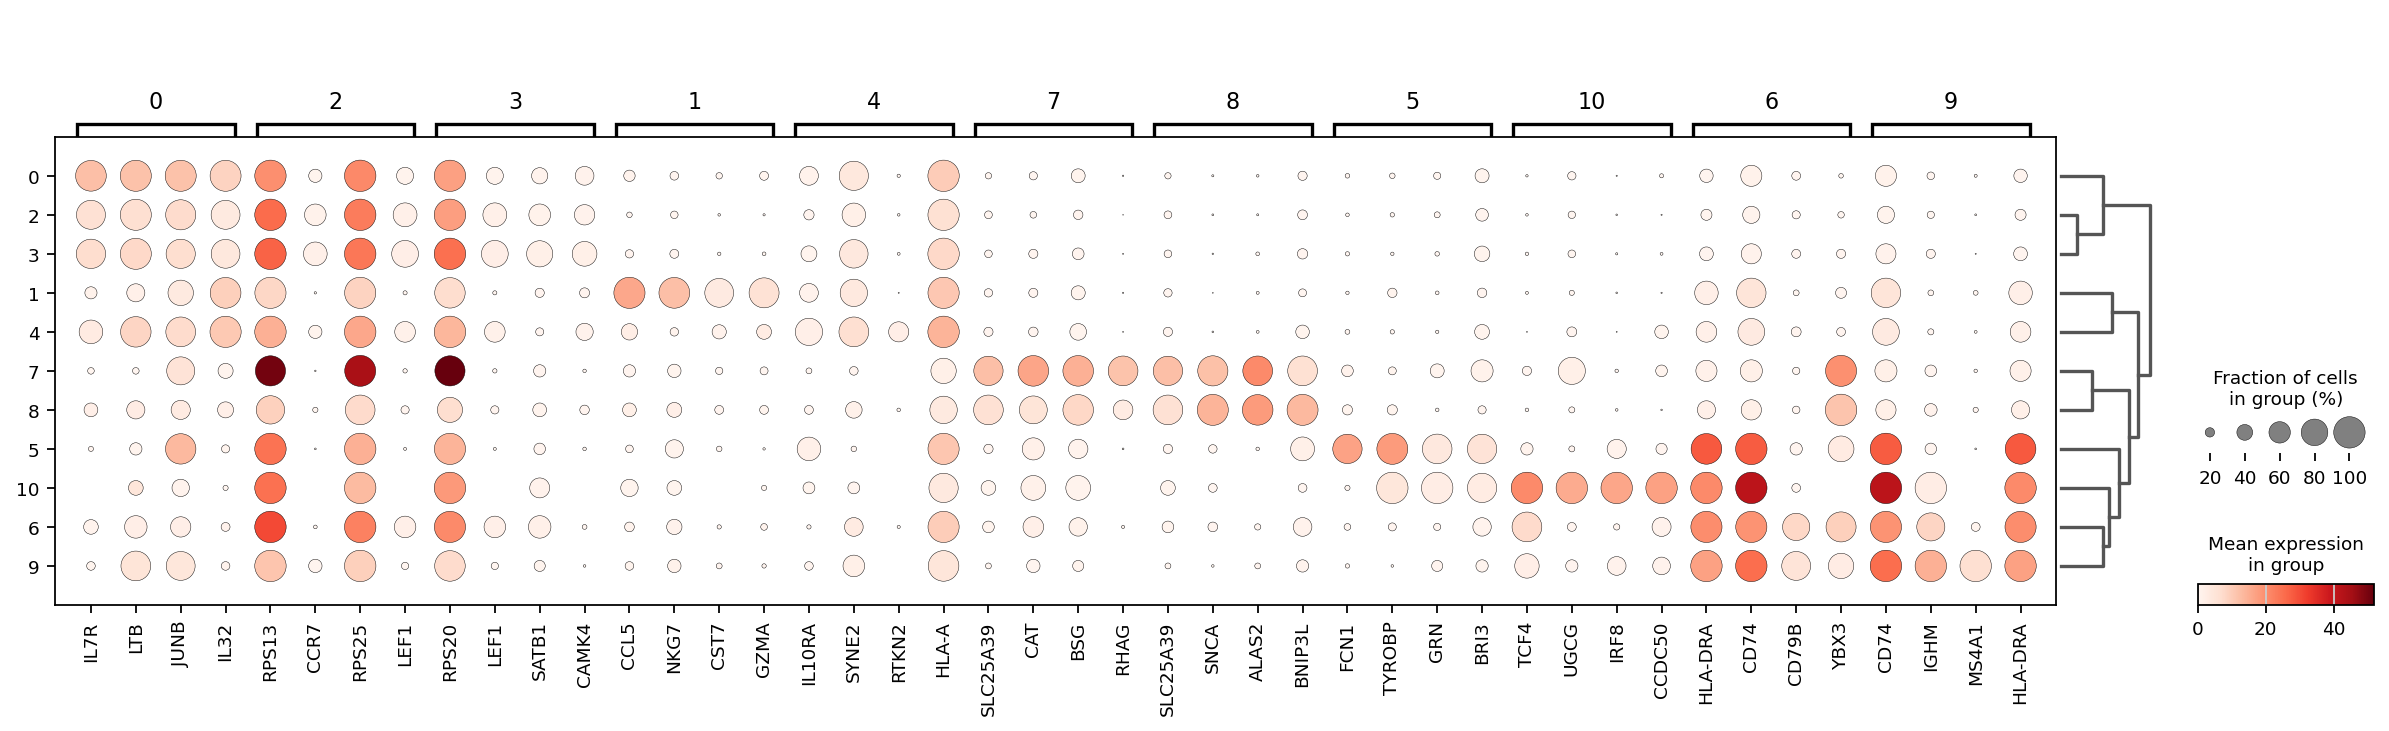

In [72]:
sc.tl.dendrogram(adata, groupby='leiden')
sc.pl.rank_genes_groups_dotplot(adata, n_genes=4, key='t-test', groupby='leiden')

In [73]:
result = adata.uns['t-test']
groups = result['names'].dtype.names
df = pd.DataFrame(
    {group + '_' + key[:5]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'pvals_adj', 'scores']})

threshold = 0.05
significant_mask = pd.concat(
    [df[group + '_pvals'] < threshold for group in groups], axis=1).any(axis=1)
significant_df = df[significant_mask]
significant_df.head()

,0_names,0_logfo,0_pvals,0_score,1_names,1_logfo,1_pvals,1_score,2_names,2_logfo,...,8_pvals,8_score,9_names,9_logfo,9_pvals,9_score,10_names,10_logfo,10_pvals,10_score
0,IL7R,13.007256,3.235172e-51,18.018177,CCL5,23.517994,3.578298e-89,28.034555,RPS13,9.431920,...,3.223855e-13,10.328140,CD74,29.362583,1.370522e-13,14.234459,TCF4,30.442772,0.000002,11.415246
1,LTB,11.158408,1.175188e-34,14.124372,NKG7,18.522038,5.817982e-69,22.830355,CCR7,2.110828,...,5.388356e-13,10.259623,IGHM,21.110868,1.423751e-10,10.951138,UGCG,24.207561,0.000005,10.202518
2,JUNB,8.577457,6.865274e-25,11.544402,CST7,6.966251,6.378372e-69,22.593266,RPS25,7.792915,...,1.828748e-12,9.878640,MS4A1,12.930360,1.693577e-08,8.668327,IRF8,26.656034,0.000008,9.627626
3,IL32,5.315573,1.996486e-24,11.268943,GZMA,9.301077,1.510805e-70,22.254791,LEF1,1.578545,...,4.810408e-12,9.612137,HLA-DRA,19.429686,1.206812e-08,8.549418,CCDC50,27.005661,0.000013,9.033738
4,ANXA1,3.794103,1.435443e-23,11.105206,CD8A,5.452427,5.036541e-48,17.549295,EEF1B2,5.486145,...,1.130094e-11,9.271228,CD79A,10.155417,2.583909e-07,7.463726,PHACTR1,6.975841,0.000027,8.296417


#### 10.5 DE Testing with `use_raw = False` & `layer = 'raw_counts'` AFTER deleting adata.raw
Finally, to use the log1p data, it looks like you need to DELETE your `adata.raw.X` and then run DE testing. This will default to adata.X which is scaled. So important to keep in mind here is -- no raw data, no way to get the raw transcripts for DE testing. 

In [74]:
adata.raw = None
adata.raw.X

AttributeError: 'NoneType' object has no attribute 'X'

In [75]:
sc.tl.rank_genes_groups(adata, 
                        'leiden', 
                        method='t-test', 
                        key_added = 't-test', 
                        use_raw = False, 
                        layer = 'raw_counts')

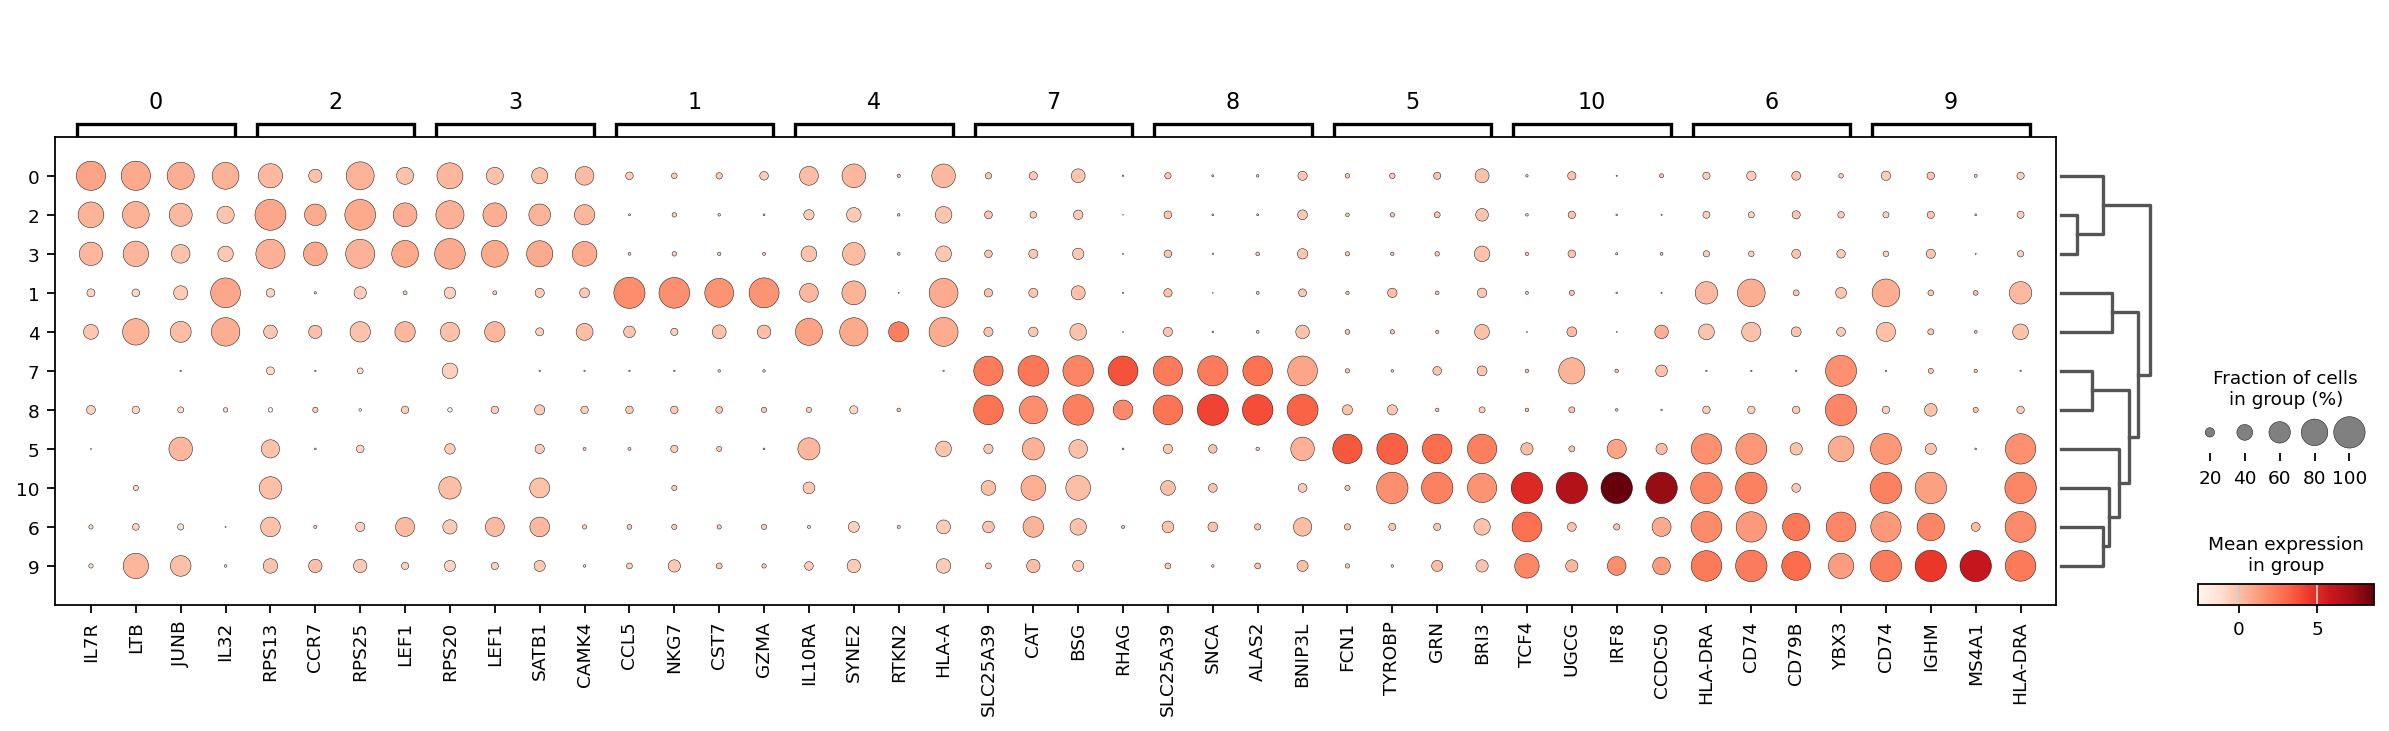

In [76]:
sc.tl.dendrogram(adata, groupby='leiden')
sc.pl.rank_genes_groups_dotplot(adata, n_genes=4, key='t-test', groupby='leiden')

In [77]:
result = adata.uns['t-test']
groups = result['names'].dtype.names
df = pd.DataFrame(
    {group + '_' + key[:5]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'pvals_adj', 'scores']})

threshold = 0.05
significant_mask = pd.concat(
    [df[group + '_pvals'] < threshold for group in groups], axis=1).any(axis=1)
significant_df = df[significant_mask]
significant_df.head()

,0_names,0_logfo,0_pvals,0_score,1_names,1_logfo,1_pvals,1_score,2_names,2_logfo,...,8_pvals,8_score,9_names,9_logfo,9_pvals,9_score,10_names,10_logfo,10_pvals,10_score
0,IL7R,13.007256,3.235172e-51,18.018177,CCL5,23.517994,3.578298e-89,28.034555,RPS13,9.431920,...,3.223855e-13,10.328140,CD74,29.362583,1.370522e-13,14.234459,TCF4,30.442772,0.000002,11.415246
1,LTB,11.158408,1.175188e-34,14.124372,NKG7,18.522038,5.817982e-69,22.830355,CCR7,2.110828,...,5.388356e-13,10.259623,IGHM,21.110868,1.423751e-10,10.951138,UGCG,24.207561,0.000005,10.202518
2,JUNB,8.577457,6.865274e-25,11.544402,CST7,6.966251,6.378372e-69,22.593266,RPS25,7.792915,...,1.828748e-12,9.878640,MS4A1,12.930360,1.693577e-08,8.668327,IRF8,26.656034,0.000008,9.627626
3,IL32,5.315573,1.996486e-24,11.268943,GZMA,9.301077,1.510805e-70,22.254791,LEF1,1.578545,...,4.810408e-12,9.612137,HLA-DRA,19.429686,1.206812e-08,8.549418,CCDC50,27.005661,0.000013,9.033738
4,ANXA1,3.794103,1.435443e-23,11.105206,CD8A,5.452427,5.036541e-48,17.549295,EEF1B2,5.486145,...,1.130094e-11,9.271228,CD79A,10.155417,2.583909e-07,7.463726,PHACTR1,6.975841,0.000027,8.296417


## Part 2: What if I reload an object I saved after processing?
Sometimes the saved object acts up so I'll also pull it back from where I saved it to see whats up. 

In [78]:
adata_2 = sc.read_h5ad('dummy_obj.h5ad')

> Upon reload everything looks fine. 

In [79]:
adata_2.raw.X

<Compressed Sparse Row sparse matrix of dtype 'uint16'
	with 3333110 stored elements and shape (1606, 33538)>

In [80]:
raw_counts = adata_2.raw.X
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.9381176289908189
Miniumum value: 0
Maximum value: 21119


In [81]:
adata_2.X

array([[-0.28886133, -0.14728796, -0.55628448, ..., -0.57205943,
        -0.09769635, -0.52180199],
       [-0.28886133, -0.14728796, -0.55628448, ..., -0.57205943,
         3.15226178, -0.52180199],
       [-0.28886133, -0.14728796, -0.55628448, ..., -0.57205943,
        -0.09769635, -0.52180199],
       ...,
       [-0.28886133, -0.14728796, -0.55628448, ...,  2.30848677,
        -0.09769635,  2.86632316],
       [-0.28886133, -0.14728796,  2.31718545, ..., -0.57205943,
        -0.09769635, -0.52180199],
       [-0.28886133, -0.14728796, -0.55628448, ..., -0.57205943,
        -0.09769635, -0.52180199]])

In [82]:
raw_counts = adata_2.X
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.0
Miniumum value: -4.6998273038487035
Maximum value: 10.0


In [83]:
adata_2.layers['raw_counts']

<Compressed Sparse Row sparse matrix of dtype 'uint16'
	with 1043947 stored elements and shape (1606, 5017)>

In [84]:
raw_counts = adata_2.layers['raw_counts']
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.8704346690740252
Miniumum value: 0
Maximum value: 3006


In [85]:
adata_2.X = adata_2.layers['raw_counts']

In [86]:
adata_2.raw.X

<Compressed Sparse Row sparse matrix of dtype 'uint16'
	with 3333110 stored elements and shape (1606, 33538)>

In [87]:
raw_counts = adata_2.raw.X
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.9381176289908189
Miniumum value: 0
Maximum value: 21119


In [88]:
adata_2.X

<Compressed Sparse Row sparse matrix of dtype 'uint16'
	with 1043947 stored elements and shape (1606, 5017)>

In [89]:
raw_counts = adata_2.X
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.8704346690740252
Miniumum value: 0
Maximum value: 3006


In [90]:
adata_2.layers['raw_counts']

<Compressed Sparse Row sparse matrix of dtype 'uint16'
	with 1043947 stored elements and shape (1606, 5017)>

In [91]:
raw_counts = adata_2.layers['raw_counts']
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.8704346690740252
Miniumum value: 0
Maximum value: 3006


In [92]:
adata_2

AnnData object with n_obs × n_vars = 1606 × 5017
    obs: 'adt_qc_flag', 'adt_umis', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'ext_l1', 'ext_l2', 'ext_l3', 'healthy_l1', 'healthy_l2', 'healthy_l3', 'aifi_l1', 'aifi_l2', 'aifi_l3', 'predicted_doublet', 'doublet_score', 'sample.sampleKitGuid', 'sample.visitDetails', 'sample.drawDate', 'sample.daysSinceFirstVisit', 'sample.diseaseStatesRecordedAtVisit', 'subject.biologicalSex', 'subject.birthYear', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'manual.time_stamp', 'manual.tissue', 'manual.disease_condition', 'manual.response', 'manual.response_type', 'manual.extracted_name', 'manual.file_paths', 'manual.batch_id', 'manual.cmv.ab_screen_index_value', 'manual.cmv.ab_screen_r

> If I bring back my saved `adata.raw` to `adata.X` using the `to_adata(()` function (basically reverting the base matrix to get rid of any and all processing)...

In [93]:
adata_2 = adata_2.raw.to_adata()

In [94]:
adata_2

AnnData object with n_obs × n_vars = 1606 × 33538
    obs: 'adt_qc_flag', 'adt_umis', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'ext_l1', 'ext_l2', 'ext_l3', 'healthy_l1', 'healthy_l2', 'healthy_l3', 'aifi_l1', 'aifi_l2', 'aifi_l3', 'predicted_doublet', 'doublet_score', 'sample.sampleKitGuid', 'sample.visitDetails', 'sample.drawDate', 'sample.daysSinceFirstVisit', 'sample.diseaseStatesRecordedAtVisit', 'subject.biologicalSex', 'subject.birthYear', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'manual.time_stamp', 'manual.tissue', 'manual.disease_condition', 'manual.response', 'manual.response_type', 'manual.extracted_name', 'manual.file_paths', 'manual.batch_id', 'manual.cmv.ab_screen_index_value', 'manual.cmv.ab_screen_

> It goes away and you need to recast it back into your `raw` before you save it again

In [95]:
adata_2.raw.X

AttributeError: 'NoneType' object has no attribute 'X'

In [96]:
raw_counts = adata_2.raw.X
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

AttributeError: 'NoneType' object has no attribute 'X'

In [ ]:
adata_2.raw = adata_2.X ## Cast it back

In [97]:
adata_2.X

<Compressed Sparse Row sparse matrix of dtype 'uint16'
	with 3333110 stored elements and shape (1606, 33538)>

In [98]:
raw_counts = adata_2.X
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

Sparsity: 0.9381176289908189
Miniumum value: 0
Maximum value: 21119


In [99]:
adata_2

AnnData object with n_obs × n_vars = 1606 × 33538
    obs: 'adt_qc_flag', 'adt_umis', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'ext_l1', 'ext_l2', 'ext_l3', 'healthy_l1', 'healthy_l2', 'healthy_l3', 'aifi_l1', 'aifi_l2', 'aifi_l3', 'predicted_doublet', 'doublet_score', 'sample.sampleKitGuid', 'sample.visitDetails', 'sample.drawDate', 'sample.daysSinceFirstVisit', 'sample.diseaseStatesRecordedAtVisit', 'subject.biologicalSex', 'subject.birthYear', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'manual.time_stamp', 'manual.tissue', 'manual.disease_condition', 'manual.response', 'manual.response_type', 'manual.extracted_name', 'manual.file_paths', 'manual.batch_id', 'manual.cmv.ab_screen_index_value', 'manual.cmv.ab_screen_

> but when you do this for some crazy reason, you LOSE the layer you saved? My intuition here is that when you bring back all values of `var`, you get rid of any saved data that has the adjusted number of `var`'s.

In [100]:
adata_2.layers['raw_counts']

KeyError: 'raw_counts'

In [ ]:
raw_counts = adata_2.layers['raw_counts']
print('Sparsity:', np.mean(raw_counts == 0))
print('Miniumum value:', raw_counts.min())
print('Maximum value:', raw_counts.max())

In [104]:
import session_info
import backports  
session_info.show(excludes=['google3'])